In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import Dans_Diffraction as dif
import pandas as pd

print(np.__version__)

tf.config.run_functions_eagerly(True)




%config InlineBackend.figure_format = 'svg' # make figures appears in .svg style

1.26.0


In [2]:
def shift_atoms_p63(cif_file, output_file="cif/temp_cif.cif", Pr1_1_dx=0, Pr1_1_dy=0, O1_1_dy=0, O1_1_dz=0, Ni1_1_dy=0,
                           Ni1_2_dy=0):
    """
    Returns the adjusted CIF file with the new atomic positions
    :param cif_file: CIF file to be adjusted
    :param output_file: Name of the new CIF file
    :param Pr1_1_dx: Pr Atom shift x
    :param Pr1_1_dy: Pr Atom shift y
    :param O1_1_dy: O Atom shift y
    :param O1_1_dz: O Atom shift z
    :param Ni1_1_dy: Ni Atom shift y
    :param Ni1_2_dy: Ni Atom shift y
    """
    modifications = {
        'Pr1_1': {'x': Pr1_1_dx, 'y': Pr1_1_dy},
        'O1_1': {'y': O1_1_dy, 'z': O1_1_dz},
        'Ni1_1': {'y': Ni1_1_dy},
        'Ni1_2': {'y': Ni1_2_dy},
    }

    with open(cif_file, 'r') as file:
        lines = file.readlines()

    atom_section = False
    modified_lines = []

    for line in lines:
        if line.startswith("_atom_site_fract_symmform"):
            atom_section = True
            modified_lines.append(line)
            continue

        if line.startswith("_iso_displacivemode_number"):
            atom_section = False
            modified_lines.append(line)
            continue

        if atom_section:
            parts = line.split()
            if len(parts) < 8:
                modified_lines.append(line)
                continue

            atom_label = parts[0]
            if atom_label in modifications:
                for i, key in enumerate(['x', 'y', 'z']):
                    if key in modifications[atom_label]:
                        parts[4 + i] = str(float(parts[4 + i]) + modifications[atom_label][key])
            modified_lines.append(" ".join(parts) + "\n")
        else:
            modified_lines.append(line)

    with open(output_file, 'w') as file:
        file.writelines(modified_lines)
    return output_file

def transform_list_hkl_p63(hkl_list):
    """
    Function to transform a list of hkl vectors from the old cell to the new cell
    :param hkl_list: List of hkl vectors
    :return: List of hkl vectors in the new cell
    2c,-2a-2b,a-b
    """
    res = []
    for hkl in hkl_list:
        h_new = 2 * hkl[2]
        k_new = -2 * (hkl[0] + hkl[1])
        l_new = (hkl[0] - hkl[1])
        res.append([h_new, k_new, l_new])
    return np.array(res)


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [3]:
def fun_tf(x, pars):
    """
    Function depending on parameters to be fitted.

    Parameters
    ----------
    x : 3D-array[h,k,l]
        N-element vector
    pars : 1D-array[float]
        Six-element vector
    """
    cif_file = '/home/mariolb/repos/CrystalClearFit/DistortionFit/cif/P63_giant_cell.cif'
    temp_cif = '/home/mariolb/repos/CrystalClearFit/DistortionFit/cif/PrNiO2/temp_cif.cif'
    Pr1_1_dx = pars[0]
    Pr1_1_dy = pars[1]
    O1_1_dy = pars[2]
    O1_1_dz = pars[3]
    Ni1_1_dy = pars[4]
    Ni1_2_dy = pars[5]
    # also include rotated positions in future
    modified_cif = shift_atoms_p63(cif_file, temp_cif, Pr1_1_dx, Pr1_1_dy, O1_1_dy, O1_1_dz, Ni1_1_dy, Ni1_2_dy)
    xtl = dif.Crystal(modified_cif)
    intensities_dif = xtl.Scatter.intensity(x, scattering_type='xray', int_hkl=True, energy_kev=73, temperature=673)
    return intensities_dif / tf.max(intensities_dif)

Sample the model parameters (fitting parameters)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths

In [4]:
experimental_data = pd.read_csv('/home/mariolb/repos/CrystalClearFit/DistortionFit/new_data.csv')

hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list_trans = transform_list_hkl_p63(hkl_list)

max_par_value = 0.01
print(experimental_data.shape)

(866, 16)


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

In [5]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list_trans
labels = experimental_data["intensity_exp"].tolist()
# labels /= np.max(labels)


Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [6]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_par_value, **kwargs):
        super().__init__(**kwargs)
        self.max_par_value = max_par_value

    def build(self, input_shape):
        # Define six trainable parameters.
        self.a = self.add_weight(name='a', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.b = self.add_weight(name='b', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.c = self.add_weight(name='c', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.d = self.add_weight(name='d', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.e = self.add_weight(name='e', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.f = self.add_weight(name='f', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        x = inputs

        # Parameters should be between max_par_value and 1
        a = self.max_par_value * tf.tanh(self.a)
        b = self.max_par_value * tf.tanh(self.b)
        c = self.max_par_value * tf.tanh(self.c)
        d = self.max_par_value * tf.tanh(self.d)
        e = self.max_par_value * tf.tanh(self.e)
        f = self.max_par_value * tf.tanh(self.f)

        # Note: clipping leads to bad performance (non-smooth gradient landscape)
        # a = tf.clip_by_value(self.a, 0.0, 1.0)
        # b = tf.clip_by_value(self.b, 0.0, 1.0)
        # c = tf.clip_by_value(self.c, 0.0, 1.0)
        # d = tf.clip_by_value(self.d, 0.0, 1.0)
        # e = tf.clip_by_value(self.e, 0.0, 1.0)
        # f = tf.clip_by_value(self.f, 0.0, 1.0)
        
        return fun_tf(inputs, [a, b, c, d, e, f])

Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [7]:
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred))/tf.reduce_sum(tf.abs(y_true))

def r_factor_metric(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))/tf.reduce_sum(tf.abs(y_true))

optim = tf.keras.optimizers.Adam(learning_rate=1e-2)
# optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
# optim = tf.keras.optimizers.SGD(learning_rate=1)
loss = tf.keras.losses.MeanSquaredError()
# loss = tf.keras.losses.MeanAbsoluteError()
# loss = RFactorLoss()

Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

In [8]:
histories = []
n_iter = 5

min_loss = np.inf
best_pars = None

for i in range(n_iter):

    # Create the model
    inputs = tf.keras.Input(shape=(n_dim,))
    outputs = FunAsLayer(max_par_value)(inputs)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optim,
        loss=loss,
        metrics=[r_factor_metric]
    )

    history = model.fit(
        x=features,
        y=labels,
        batch_size=64,
        epochs=500,
        verbose=0,
        shuffle=True # not sure whether this matters
        # callbacks=[cb]
    )

    histories.append(history)

    # Check final loss
    final_loss = history.history['loss'][-1]

    if final_loss < min_loss:
        # Update best model parameters
        best_model_pars = [max_par_value * tf.sigmoid(model.layers[-1].get_weights()[i]).numpy() for i in range(6)]
        min_loss = final_loss
        rf = r_factor_metric(labels, fun_tf(features, best_model_pars))
        print(f"Iteration {i+1} - New best loss: {min_loss:.2e} (R-factor: {rf:.2e})")


TypeError: Exception encountered when calling FunAsLayer.call().

[1mCould not automatically infer the output shape / dtype of 'fun_as_layer' (of type FunAsLayer). Either the `FunAsLayer.call()` method is incorrect, or you need to implement the `FunAsLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

'NoneType' object cannot be interpreted as an integer[0m

Arguments received by FunAsLayer.call():
  • args=('<KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>',)
  • kwargs=<class 'inspect._empty'>

Plotting the learning curves

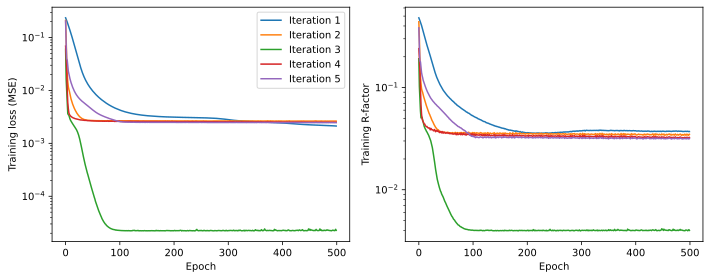

In [29]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_xlabel(f"Epoch")
ax1.set_ylabel(f"Training loss (MSE)")
ax1.set_yscale('log')
ax2.set_xlabel(f"Epoch")
ax2.set_ylabel(f"Training R-factor")
ax2.set_yscale('log')

for i, history in enumerate(histories):

    train_loss = history.history['loss']
    train_metric = history.history['r_factor_metric']
    epochs = np.arange(len(history.history['loss']))
    ax1.plot(epochs, train_loss, label=f"Iteration {i+1}")
    ax2.plot(epochs, train_metric)

ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

Compare best estimated model parameters with ground truth values

Note: the % deviation from the ground truth values must be taken with a grain of salt here because the function consists of two Gaussians, which can be in any order!

Final MSE (R2): 1.66e-07 (3.61e-04)
True model parameters: [0.89286015 0.33197981 0.82122912 0.04169663 0.10765668 0.59505206]
Fitted model parameters: [0.8925995826721191, 0.33206501603126526, 0.8210735321044922, 0.04181680828332901, 0.10756711661815643, 0.5956214666366577]
Deviation (%): [0.03 0.03 0.02 0.29 0.08 0.1 ]


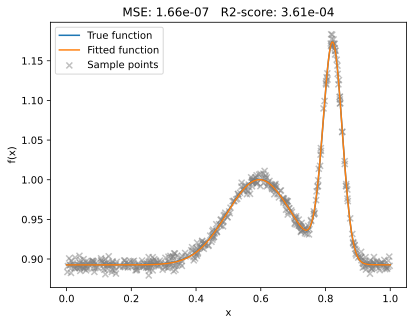

In [30]:
# model = tf.keras.models.load_model("model")
# model_pars = [tf.sigmoid(model.layers[1].get_weights()[i]).numpy() for i in range(true_pars.size)]
# model_pars = [tf.sigmoid(model.layers[-1].get_weights()[i]).numpy() for i in range(true_pars.size)]

msef = np.mean((fun_tf(features, true_pars) - fun_tf(features, best_model_pars))**2)
r2f = r_factor_metric(fun_tf(features, true_pars), fun_tf(features, best_model_pars))
deviation = np.abs((true_pars - best_model_pars)/true_pars) * 100
print(f"Final MSE (R2): {msef:.2e} ({r2f:.2e})")
print(f"True model parameters: {true_pars}")
print(f"Fitted model parameters: {best_model_pars}")
print(f"Deviation (%): {np.round(deviation, 2)}")

# Plotting
x = np.linspace(0.0, 1.0, 1000)
y = fun_tf(x, true_pars)
yf = fun_tf(x, best_model_pars)
plt.figure()
plt.plot(x, y, label="True function")
plt.plot(x, yf, label="Fitted function")
plt.scatter(features, labels, marker='x', color='grey', label="Sample points", alpha=0.5)
plt.title(f"MSE: {msef:.2e}   R2-score: {r2f:.2e}")
# plt.title(f"MSE: {msef:.2e}   R2-score: {r2f:.2e}\nDeviation of parameters (%): [{'  '.join([f'{d:.2f}' for d in deviation])}]")
plt.xlabel(f"x")
plt.ylabel(f"f(x)")
# plt.title(f"Deviation of parameters (%):\n{np.round(deviation,2)}")
plt.legend()
plt.show()

# [ 1.96  0.5  11.98  7.96 48.67 50.31] (MSE)
# [ 0.36  0.58  8.88  7.22 50.35 52.57] (R2)